# 🚨 Robust Phishing Email Detection (TF-IDF + Custom Features + XGBoost)
This notebook builds a **production-level** phishing detector that generalizes well to new emails.

In [1]:
!pip install pandas scikit-learn xgboost matplotlib joblib


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import joblib

## 📥 Load & Clean Dataset

In [3]:
df = pd.read_csv('D:\\mini_project\\Phishing_Email.csv')
df = df.dropna(subset=['Email Text']).copy()
df['Label'] = df['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})

## ✨ Inject Synthetic Phishing Examples

In [5]:
synthetic = [
    'Urgent: Your account has been suspended. Click the link below to verify.',
    'Confirm your email immediately or we will lock your account.',
    'Dear user, your mailbox has exceeded its storage limit. Login now.',
    'Suspicious login detected. Reset your password using this secure link.',
    'You have won a gift card. Claim now by entering your details here.'
]
df_syn = pd.DataFrame({'Email Text': synthetic, 'Label': 1})
df = pd.concat([df[['Email Text', 'Label']], df_syn], ignore_index=True)

## 🧠 Feature Engineering

In [6]:
class CustomTextFeatures:
    def transform(self, X):
        feats = pd.DataFrame()
        feats['num_links'] = X.apply(lambda x: len(re.findall(r'http[s]?://', x.lower())))
        feats['has_phishing_keywords'] = X.apply(lambda x: int(any(k in x.lower() for k in [
            'verify', 'account suspended', 'login now', 'reset password', 'gift card'])))
        feats['uses_non_https_links'] = X.apply(lambda x: int('http://' in x.lower() and 'https://' not in x.lower()))
        feats['suspicious_url_pattern'] = X.apply(lambda x: int(bool(re.search(r'\b(secure|login|update|account)[-_]?(info|center)?\b', x.lower()))))
        feats['greeting_generic'] = X.apply(lambda x: int('dear customer' in x.lower() or 'dear user' in x.lower()))
        return feats

## ✂️ Extract TF-IDF + Custom Features

In [7]:
tfidf = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2)
X_text = df['Email Text']
y = df['Label']
X_tfidf = tfidf.fit_transform(X_text)
custom = CustomTextFeatures()
X_custom = custom.transform(X_text)
scaler = StandardScaler()
X_custom_scaled = scaler.fit_transform(X_custom)
from scipy.sparse import hstack
X_all = hstack([X_tfidf, X_custom_scaled])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)

## ⚙️ Train XGBoost Classifier

In [9]:
model = XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

c:\Users\Cherishya\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:05:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

## 📊 Evaluation

In [10]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2265
           1       0.92      0.98      0.95      1464

    accuracy                           0.96      3729
   macro avg       0.96      0.96      0.96      3729
weighted avg       0.96      0.96      0.96      3729



## 📈 ROC Curve

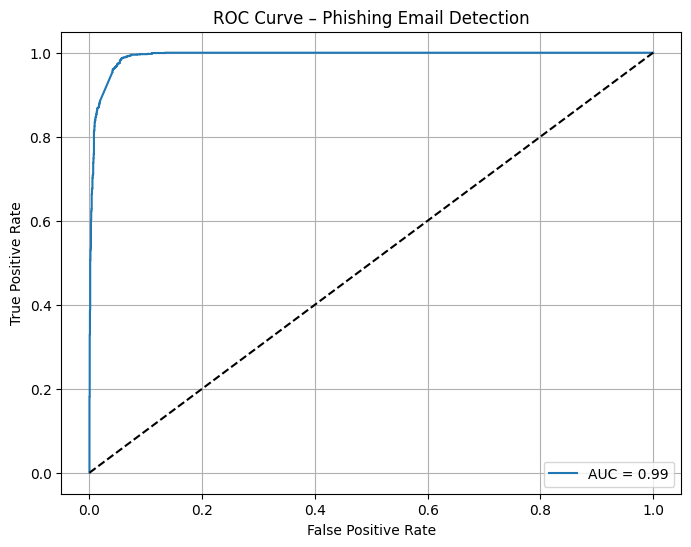

In [10]:
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Phishing Email Detection')
plt.legend()
plt.grid(True)
plt.show()

## 💾 Save Model + Transformers

In [11]:
joblib.dump(model, 'xgb_phishing_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(scaler, 'custom_scaler.pkl')

['custom_scaler.pkl']